In [7]:
jobids="""# Submitted batch job 13992830
# Submitted batch job 13992837
# Submitted batch job 13992838"""
jobids=[i.split(' ')[-1] for i in jobids.split("\n")]

In [8]:
import numpy as np
import seaborn as sns
import torch

import umap
import matplotlib.pyplot as plt
import pandas as pd
from community import community_louvain
from torch_geometric.utils import k_hop_subgraph,to_networkx,from_networkx
import matplotlib

import utils
import plots
from model_AE import reduction_AE
from model_GAT import Encoder,SenGAE,train_GAT
from model_Sencell import Sencell
from sampling import sub_sampling_by_random
from model_Sencell import cell_optim,update_cell_embeddings
from sampling import identify_sengene_then_sencell

import logging
import os
import argparse

is_jupyter=True

parser = argparse.ArgumentParser(description='Main program for sencells')

parser.add_argument('--output_dir', type=str, default='./outputs', help='')
parser.add_argument('--exp_name', type=str, default='', help='')
parser.add_argument('--sencell_num', type=int, default=100, help='')
parser.add_argument('--retrain', action='store_true', default=False, help='')


if is_jupyter:
    args = parser.parse_args(args=[])
    args.exp_name='healthy'
    args.retrain=False  
else:
    args = parser.parse_args()
args.is_jupyter=is_jupyter


if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)

logging.basicConfig(format='%(asctime)s.%(msecs)03d [%(levelname)s] [%(filename)s:%(lineno)d] %(message)s',
                    datefmt='# %Y-%m-%d %H:%M:%S')

logging.getLogger().setLevel(logging.INFO)
logger = logging.getLogger()

# Part 1: load and process data
# cell_cluster_arr在画umap的时候用
if 's5' in args.exp_name:
    adata,cluster_cell_ls,cell_cluster_arr,celltype_names=utils.load_data()
elif 'healthy' in args.exp_name:
    adata,cluster_cell_ls,cell_cluster_arr,celltype_names=utils.load_data_healthy()
elif 'disease' in args.exp_name:
    adata,cluster_cell_ls,cell_cluster_arr,celltype_names=utils.load_data_disease()

# plots.umapPlot(adata.obsm['X_umap'],clusters=cell_cluster_arr,labels=celltype_names)

new_data,markers_index,\
sen_gene_ls,nonsen_gene_ls,gene_names=utils.process_data(adata,cluster_cell_ls,cell_cluster_arr)

gene_cell=new_data.X.toarray().T
args.gene_num=gene_cell.shape[0]
args.cell_num=gene_cell.shape[1]

print(f'cell num: {new_data.shape[0]}, gene num: {new_data.shape[1]}')

graph_nx=utils.build_graph_nx(gene_cell,cell_cluster_arr,sen_gene_ls,nonsen_gene_ls,gene_names)
logger.info("Part 1, data loading and processing end!")

cluster 数量： 13
celltype names: ['Fibroblasts', 'Basal', 'Unknown', 'Secretory', 'None', 'Myofibroblasts', 'Multiciliated lineage', 'Rare', 'Submucosal Secretory', 'Mast cells', 'EC capillary', 'EC arterial', 'T cell lineage']
---------------------  ----
Fibroblasts            2822
Basal                  2819
Unknown                1534
Secretory               154
None                    114
Myofibroblasts          109
Multiciliated lineage    42
Rare                      2
Submucosal Secretory      2
Mast cells                1
EC capillary              1
EC arterial               1
T cell lineage            1
---------------------  ----
各marker list所包含的gene数：
  Markers1    Markers2    Markers3    Markers4
----------  ----------  ----------  ----------
       126          78         145          84
total marker genes:  380


/users/PCON0022/haocheng/.conda/envs/deepmaps_env/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


highly_genes num:  2000
After highly genes dropped duplicate:  1901
Total gene num: 2244
cell num: 7602, gene num: 2244
The number of edges: 2276908


# 2022-12-07 09:40:44.283 [INFO] [1336566513.py:74] Part 1, data loading and processing end!


82
test_45.eps
16
test_29.eps
106
test_77.eps


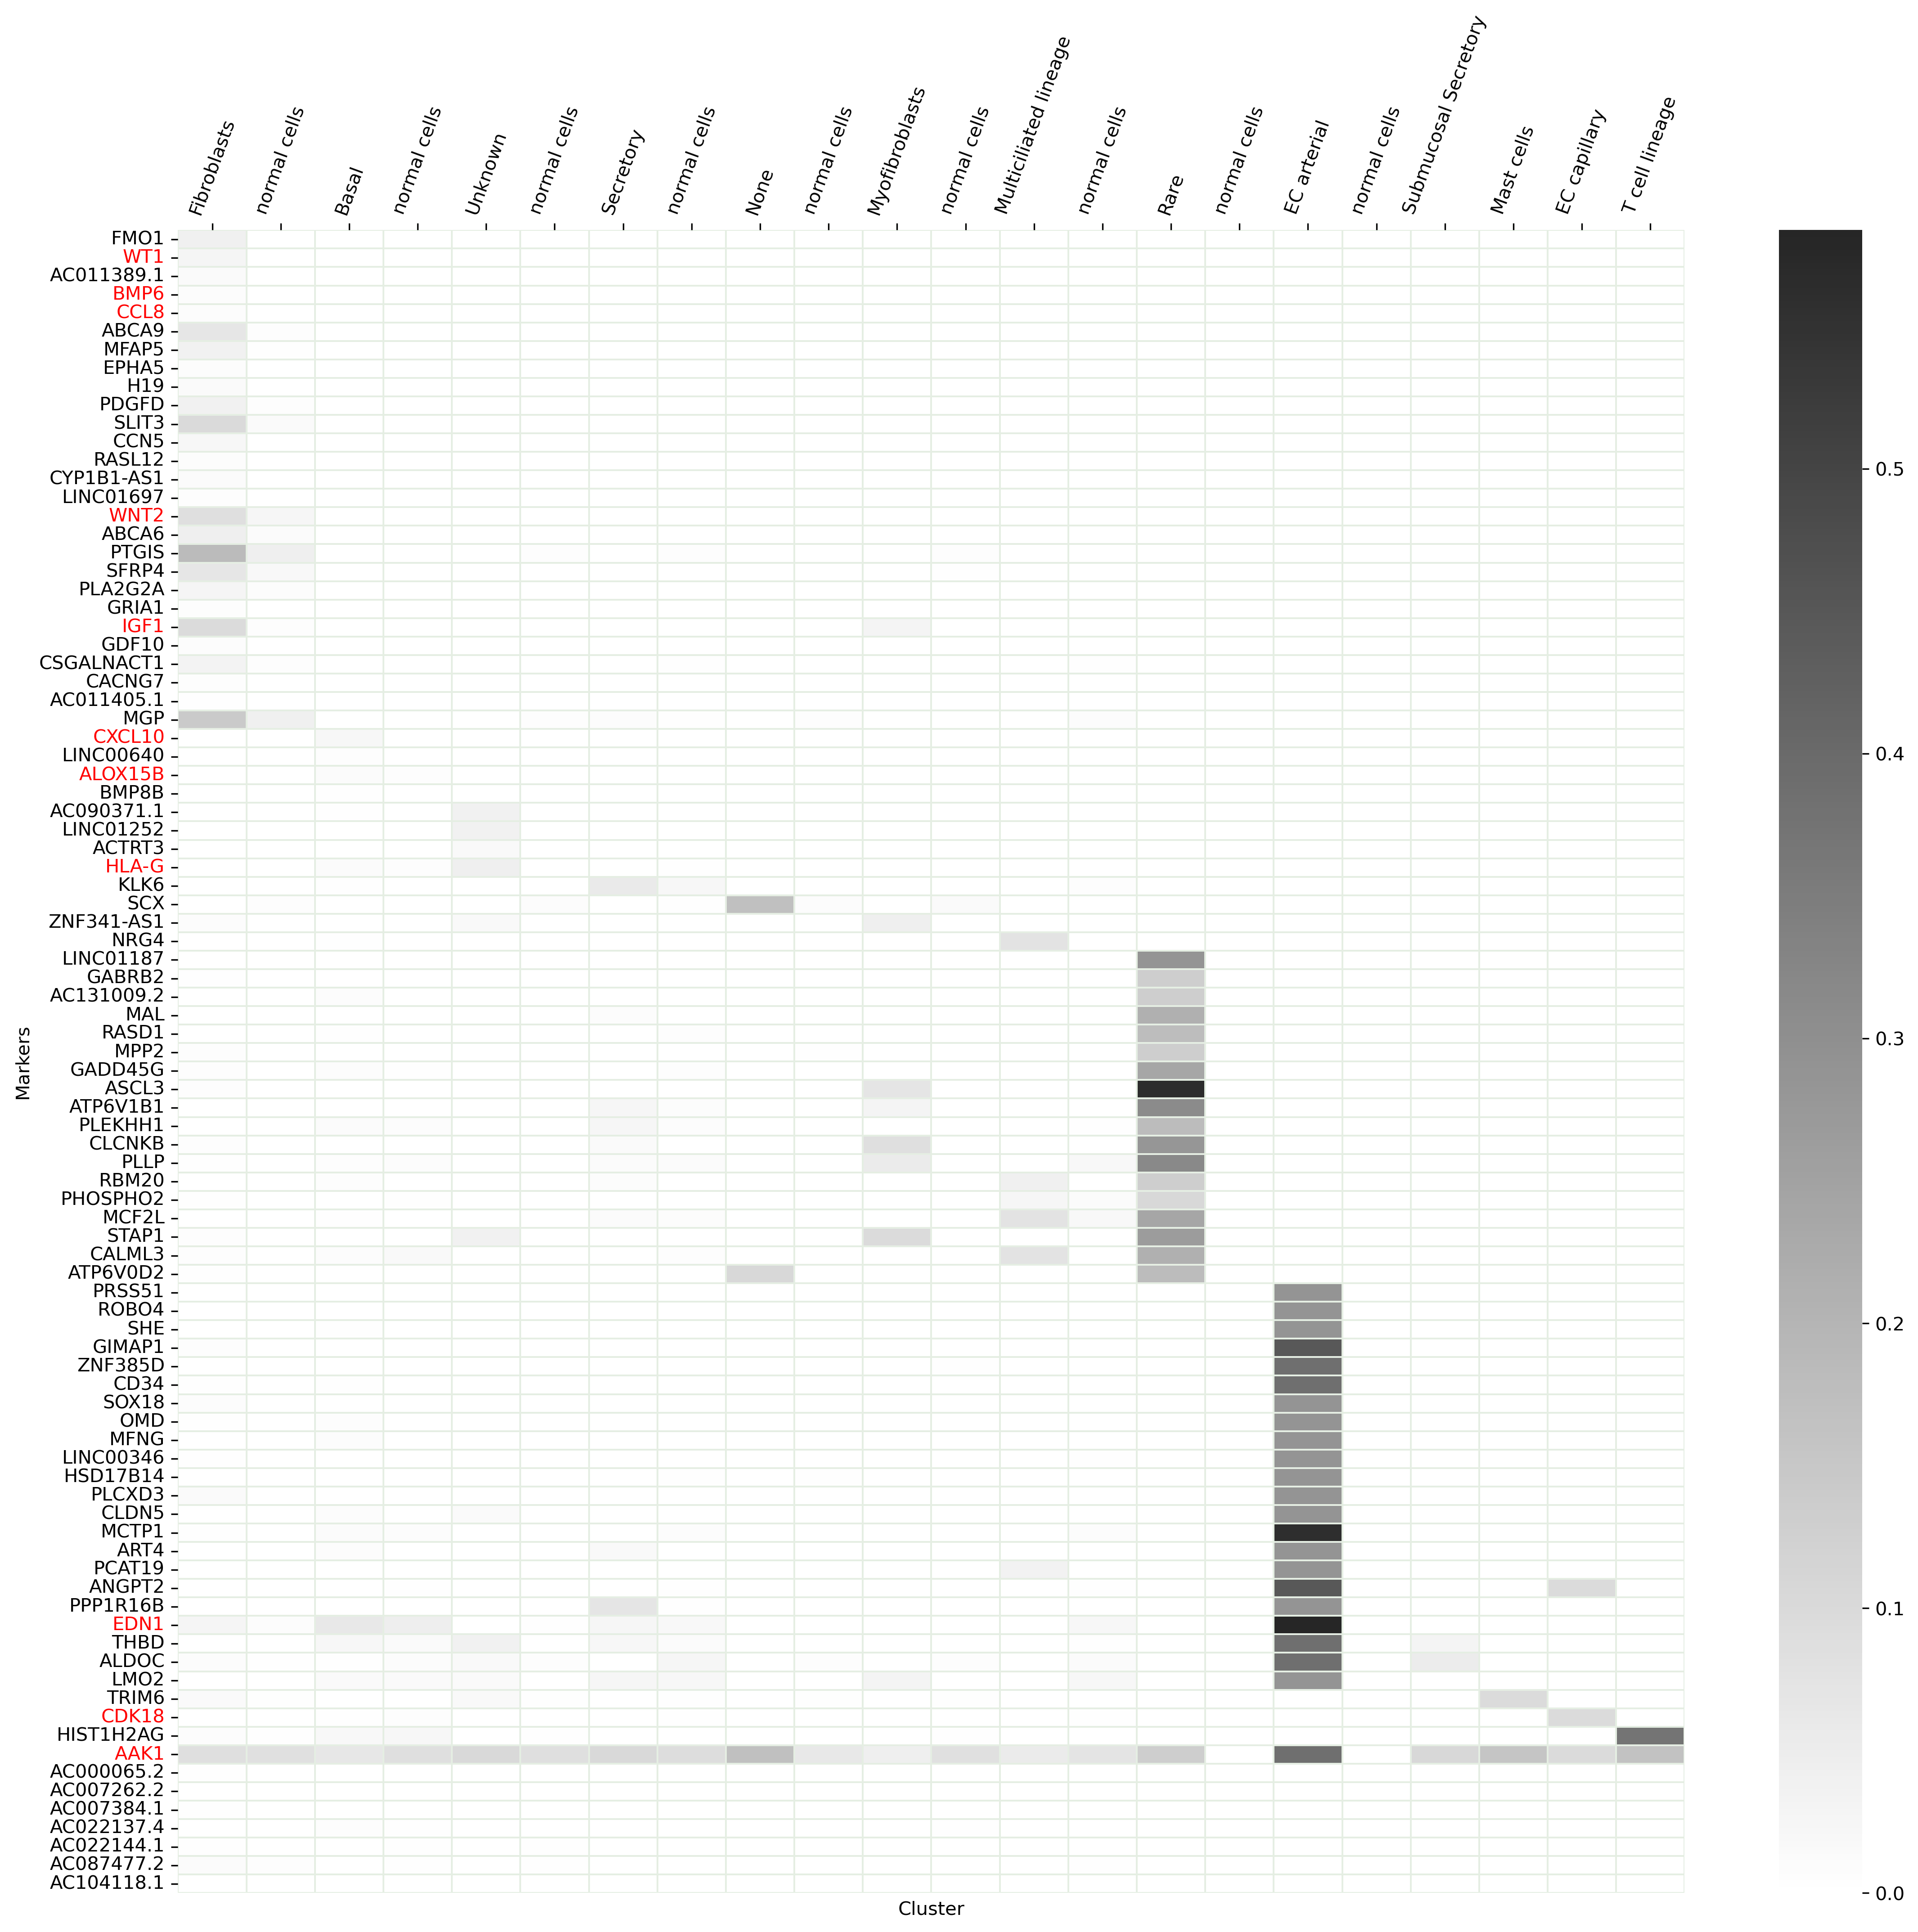

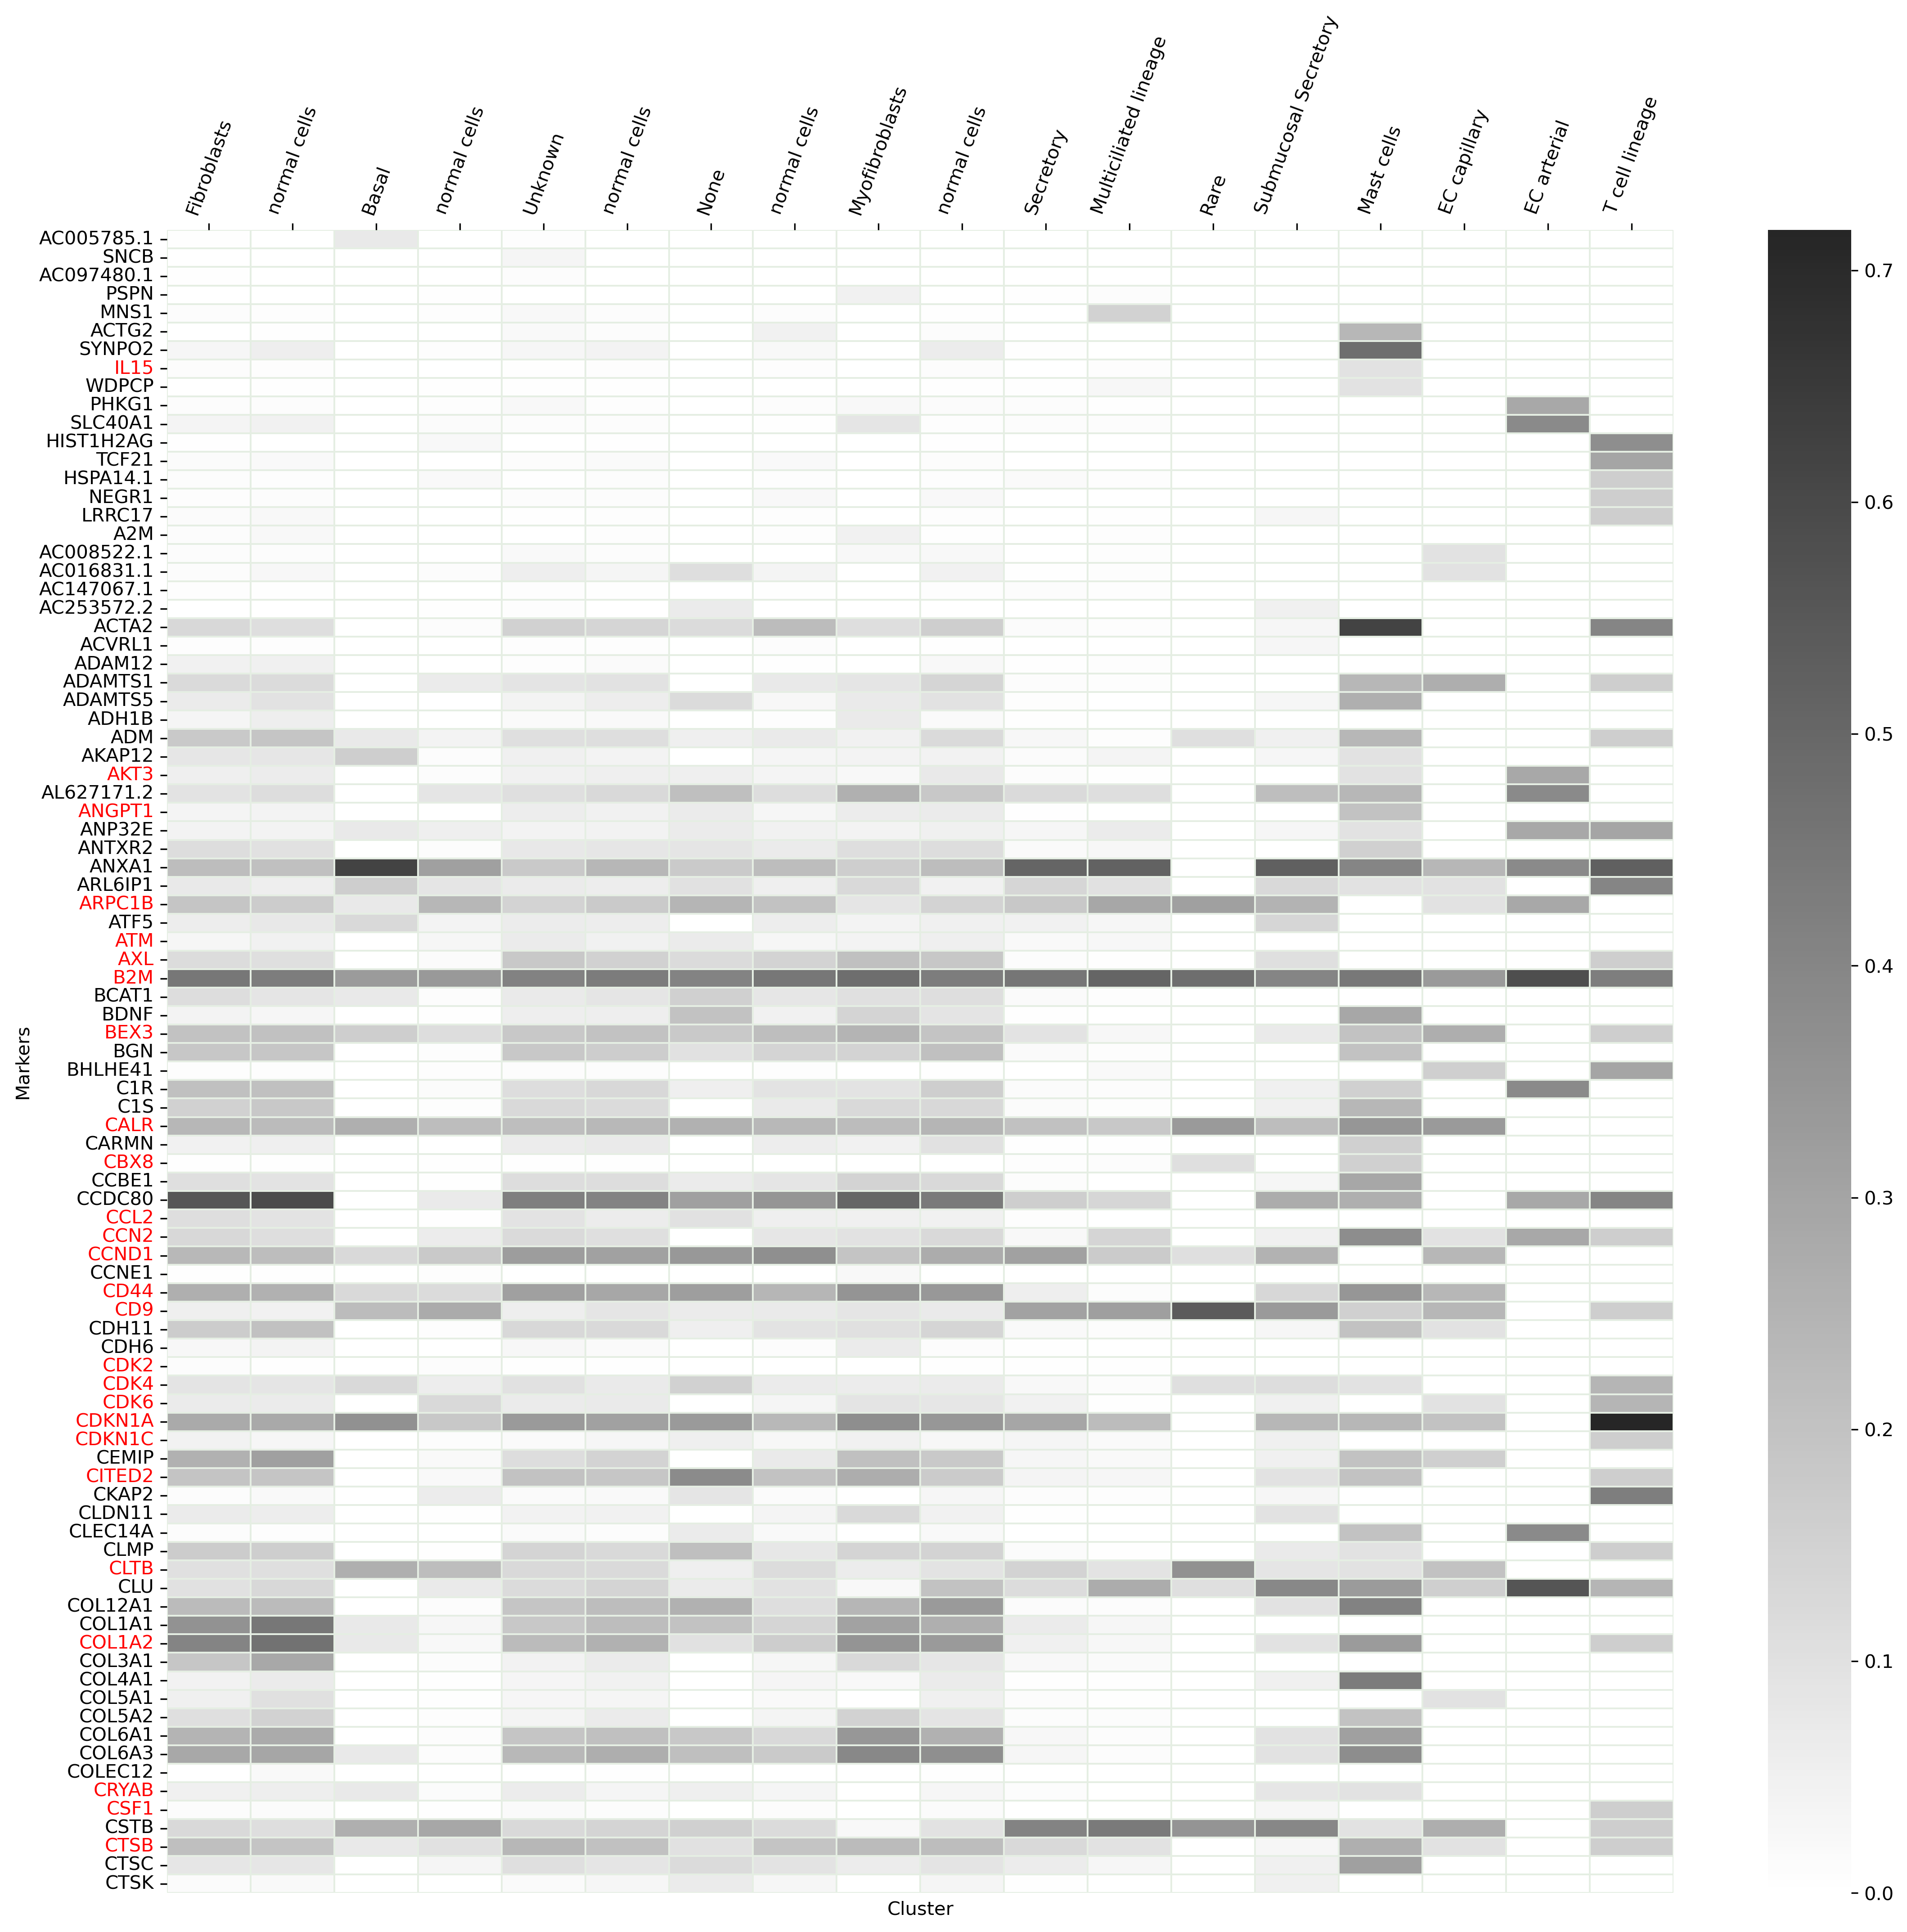

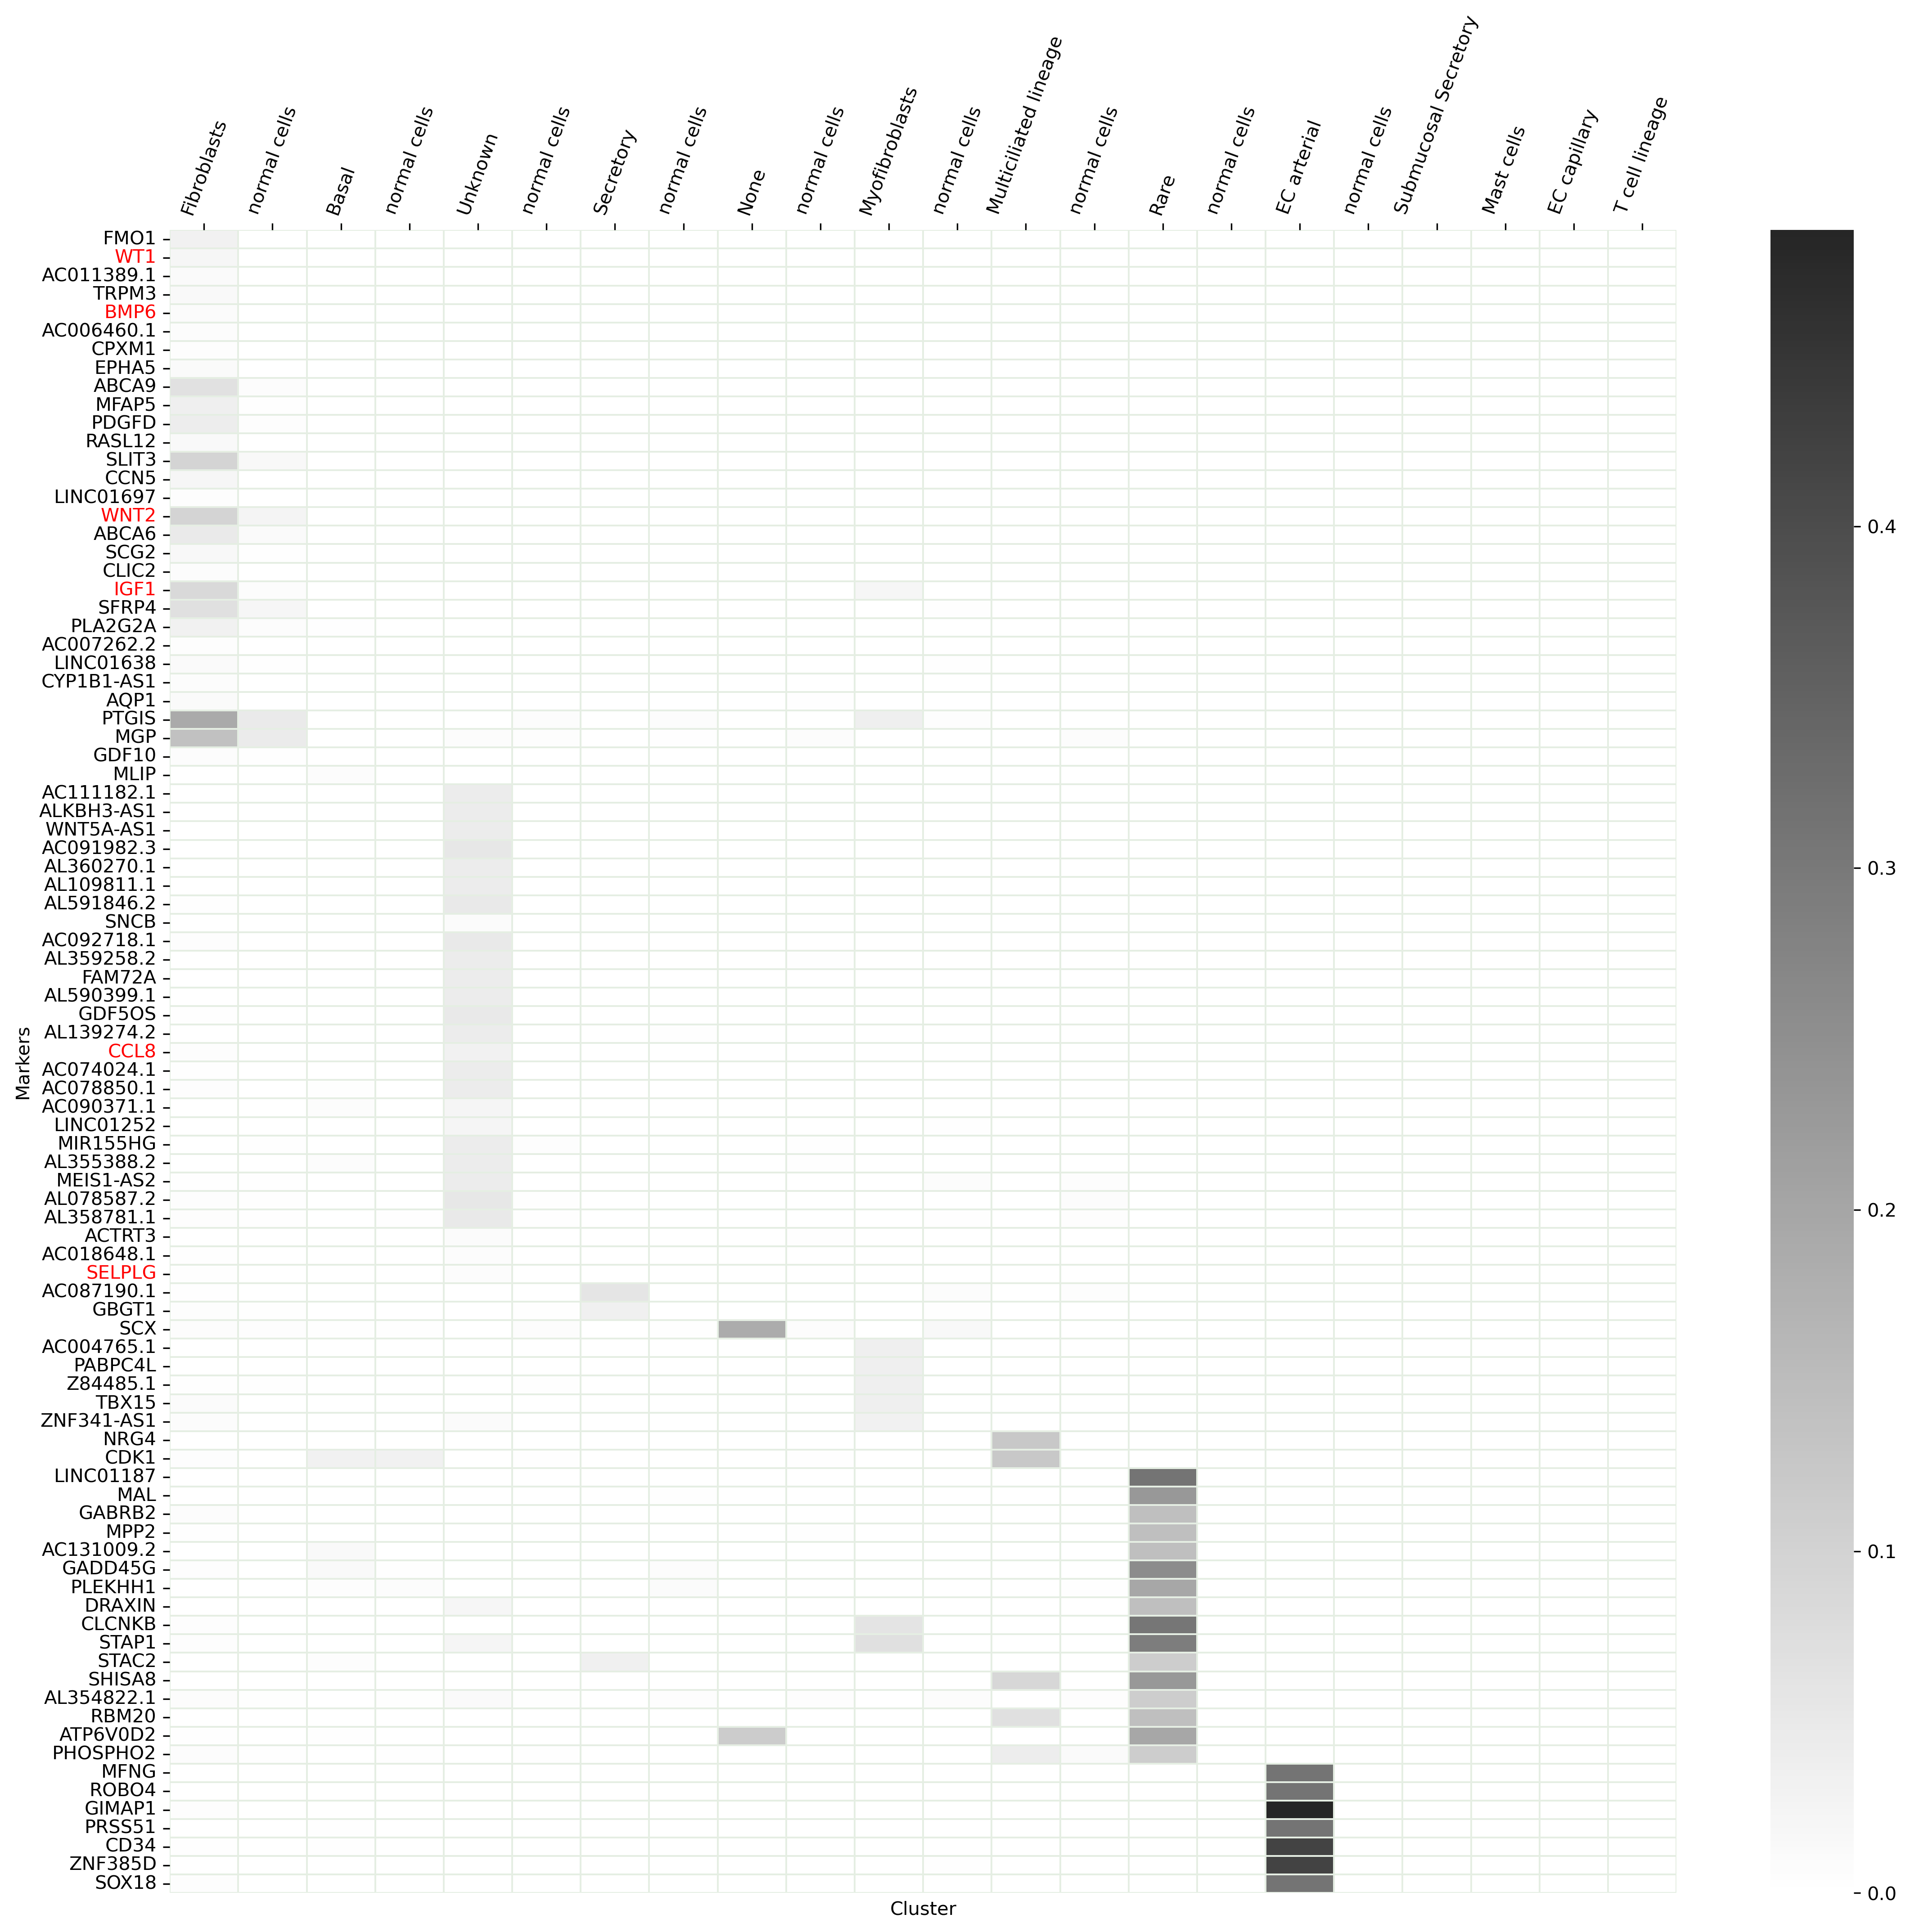

In [16]:
# sencell_dict,sen_gene_indexs=torch.load('./outputs/s5_outputs_2854.data')
# sencell_dict,sen_gene_indexs=torch.load('./outputs/s5_outputs_4310.data')
# sencell_dict,sen_gene_indexs=torch.load('./outputs/s5_outputs_5820.data')
# sencell_dict,sen_gene_indexs=torch.load('./outputs/s5_outputs_1643.data')

# cluster内部不取交集
def get_celltype_specific_genes(cluster_cell_dict,graph_nx,sen_gene_indexs,gene_names,args):
    # {cluster:gene names}
    outputs_dict={}
    total_genes=set()
    for key,value in cluster_cell_dict.items():
        # print(f'cluster: {key}')
        gene_ls=[]
        for cell_index in value:
            gene_ls=gene_ls+[i for i in graph_nx.neighbors(cell_index+args.gene_num)]
        results=set(gene_ls)
        results=results.intersection(set(sen_gene_indexs))
        results=[gene_names[i] for i in results]
        total_genes.update(results)
        outputs_dict[key]=sorted(results)
    return outputs_dict,total_genes

import plots

def get_matrix(rows,cols,outputs_dict):
    matrix=np.zeros((len(rows),len(cols)))

    for col_index in range(len(cols)):
        cluster=cols[col_index]
        genes=outputs_dict[cluster]
        for gene in genes:
            row_index=rows.index(gene)
            matrix[row_index][col_index]=1
            
    return matrix

def get_matrix_exp(rows,cols,outputs_dict):
    # cluster_cell_ls
    # gene_cell
    # gene_names
    # heatmap显示表达量
    matrix=np.zeros((len(rows),len(cols)))

    for col_index in range(len(cols)):
        cluster=cols[col_index]
        for gene in rows:
            row_index=rows.index(gene)
            cells=cluster_cell_dict[cluster]
            exp=sum(gene_cell[gene_names.index(gene)][cells])/len(cells)
            matrix[row_index][col_index]=exp
    for i,line in enumerate(matrix):
        matrix[i]=matrix[i]/sum(matrix[i])
    return matrix


def get_matrix_new(rows,cols,outputs_dict):
    results=[]
    cols_names=[]
    for col_index in range(len(cols)):
        cluster=cols[col_index]
        cols_names.append(celltype_names[cluster])
        cols_names.append('normal cells')
        all_cells=cluster_cell_ls[cluster]
        sencells=cluster_cell_dict[cluster]
        nonsencells=list(set(all_cells)-set(sencells))
        
        sencell_col=[]
        nonsencell_col=[]
        
        for gene in rows:
            exp=sum(gene_cell[gene_names.index(gene)][sencells])/len(sencells)
            sencell_col.append(exp)
            if len(nonsencells)>0:
                exp=sum(gene_cell[gene_names.index(gene)][nonsencells])/len(nonsencells)
                nonsencell_col.append(exp)
            else:
                nonsencell_col.append(0)
    
        results.append(sencell_col)
        results.append(nonsencell_col)
    
    for cluster in range(len(celltype_names)):
        if cluster not in cols:
            normal_cells=cluster_cell_ls[cluster]
            cols_names.append(celltype_names[cluster])
            exp_ls=[]
            for gene in rows:
                exp=sum(gene_cell[gene_names.index(gene)][normal_cells])/len(normal_cells)
                exp_ls.append(exp)
            results.append(exp_ls)
    
    results=np.array(results).T
    for i,line in enumerate(results):
        results[i]=results[i]/sum(results[i])

    
    return results,cols_names


def get_matrix_new1(rows,cols,outputs_dict):
    results=[]
    cols_names=[]
    for col_index in range(len(cols)):
        cluster=cols[col_index]
        cols_names.append(celltype_names[cluster])
        cols_names.append('normal cells')
        all_cells=cluster_cell_ls[cluster]
        sencells=cluster_cell_dict[cluster]
        nonsencells=list(set(all_cells)-set(sencells))
        
        sencell_col=[]
        nonsencell_col=[]
        
        for gene in rows:
            exp=sum(gene_cell[gene_names.index(gene)][sencells])/len(sencells)
            sencell_col.append(exp)
            if len(nonsencells)>0:
                exp=sum(gene_cell[gene_names.index(gene)][nonsencells])/len(nonsencells)
                nonsencell_col.append(exp)
            else:
                nonsencell_col.append(0)
    
        results.append(sencell_col)
        results.append(nonsencell_col)
    
    for cluster in range(len(celltype_names)):
        if cluster not in cols:
            normal_cells=cluster_cell_ls[cluster]
            cols_names.append(celltype_names[cluster])
            exp_ls=[]
            for gene in rows:
                exp=sum(gene_cell[gene_names.index(gene)][normal_cells])/len(normal_cells)
                exp_ls.append(exp)
            results.append(exp_ls)
    
    results=np.array(results).T

    results=(results-np.min(results))/(np.max(results)-np.min(results))
    return results,cols_names

def change_row_order(rows,cols,outputs_dict):
    # 按表达数量从少到多排序
    matrix=get_matrix(rows,cols,outputs_dict)

    results=[]
    for i,lines in enumerate(matrix):
        results.append([i,sum(lines)])
    results=sorted(results, key=lambda item: item[1])
    indexs=[i[0] for i in results]
    rows=np.array(sorted(list(total_genes)))[indexs]
    rows=list(rows)
    return rows

def change_row_order_by_list(rows,head_list):
    for i in head_list:
        if i in rows:
            rows.remove(i)
    rows=head_list+rows
    
    return rows


def find_celltype_specific_genes(rows,matrix):
    results={}
    for i,line in enumerate(matrix):
        max_index=np.argmax(line)
        if max_index in results:
            results[max_index].append(rows[i])
        else:
            results[max_index]=[rows[i]]
    
    outputs=[]
    for i in range(matrix.shape[1]):
        if i in results:
            outputs=outputs+results[i]

    return outputs


def find_celltype_specific_genes1(rows,matrix):
    results=[]
    for col in range(matrix.shape[1]):
        ct_specific=[]
        for i,line in enumerate(matrix):
            if line[col]>=0.5:
                ct_specific.append([rows[i],line[col]])
        ct_specific=sorted(ct_specific,key=lambda item: item[1],reverse=True)
        results=results+ct_specific
    
    results=[i[0] for i in results]
    return results


def find_celltype_specific_genes2(rows,matrix,cols_names):
    results=[]
    for col in range(matrix.shape[1]):
        if cols_names[col]!='normal cells':
            ct_specific=[]
            for i,line in enumerate(matrix):
                if line[col]>=0.6:
                    ct_specific.append([rows[i],line[col]])
            ct_specific=sorted(ct_specific,key=lambda item: item[1],reverse=True)
            results=results+ct_specific
    
    results=[i[0] for i in results]
    
    return results

row_gene_list=[]

def plot_heatmap(total_genes,outputs_dict):
    rows=sorted(list(total_genes))
    cols=sorted(list(outputs_dict.keys()))

    matrix,cols_names=get_matrix_new(rows,cols,outputs_dict)
    head_list=find_celltype_specific_genes2(rows,matrix,cols_names)
    
    rows=change_row_order_by_list(rows,head_list)
#     matrix,cols_names=get_matrix_new(rows,cols,outputs_dict)
    matrix1,cols_names=get_matrix_new1(rows,cols,outputs_dict)

    plt.figure(figsize=(18,16),dpi=300)
    
    split=90
    print(len(head_list))
    row_gene_list.append(rows[:split])
    ax=sns.heatmap(matrix1[:split], cmap=sns.dark_palette("white", reverse=True, as_cmap=True),
                   xticklabels=cols_names,yticklabels=rows[:split],linewidth=.5,linecolor='#e5eee3')
    ax.xaxis.tick_top()

    plt.ylabel('Markers')
    plt.xlabel("Cluster")
    # plt.get_ticklines()
    for tick in ax.get_xticklabels():
        tick.set_rotation(70)

    indexs=[]
    sen_gene_names=[gene_names[i] for i in sen_gene_ls]
    for i,j in enumerate(rows[:split]):
        if j in sen_gene_names:
            indexs.append(i)
    for i in indexs:
        ax.get_yticklabels()[i].set_color("red") 
        
    filename=f"test_{np.random.randint(100)}.eps"
    print(filename)
    plt.savefig(filename,format='eps')

for jobid in jobids:
    file_path=f'./outputs/{jobid}/healthy_{jobid}_outputs.data'
    sencell_dict,sen_gene_indexs=torch.load(file_path)
    
    cluster_cell_dict={}
    cell_cluster_ls=[v[1] for k,v in sencell_dict.items()]
    cell_index_ls=[v[3]-args.gene_num for k,v in sencell_dict.items()]
    for cluster,index in zip(cell_cluster_ls,cell_index_ls):
        if cluster in cluster_cell_dict:
            cluster_cell_dict[cluster].append(index)
        else:
            cluster_cell_dict[cluster]=[index]

    outputs_dict,total_genes=get_celltype_specific_genes(cluster_cell_dict,graph_nx,sen_gene_indexs,gene_names,args)
    
        
#     plots.umapPlot(adata.obsm['X_umap'],np.array(cell_index_ls),clusters=cluster_cell_ls,labels=celltype_names)
#     plots.subUmapPlot(adata.obsm['X_umap'],cluster_cell_dict,clusters=cluster_cell_ls,labels=celltype_names)
    plot_heatmap(total_genes,outputs_dict)

In [14]:
len(set(row_gene_list[0]).intersection(row_gene_list[2]))

48

In [15]:
48/90

0.5333333333333333